Performing grid search for Linear Regression, 


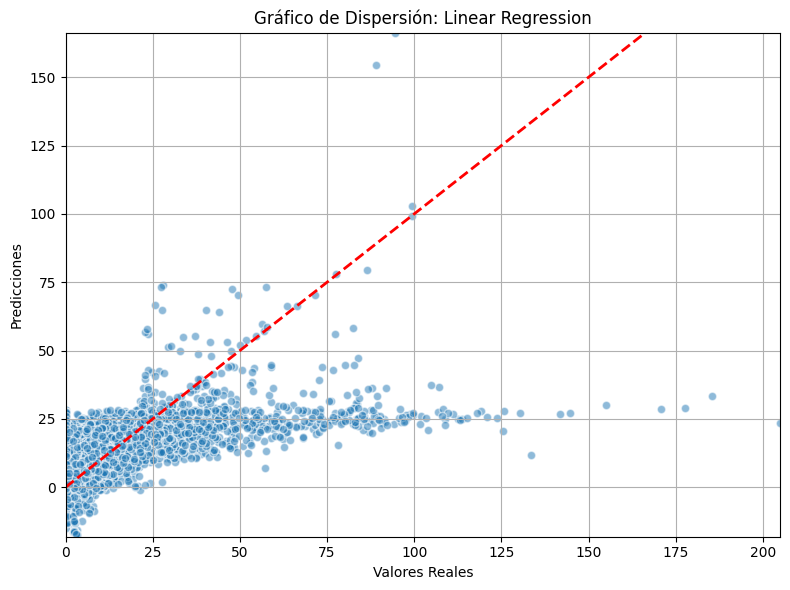

Performing grid search for Ridge Regression, 


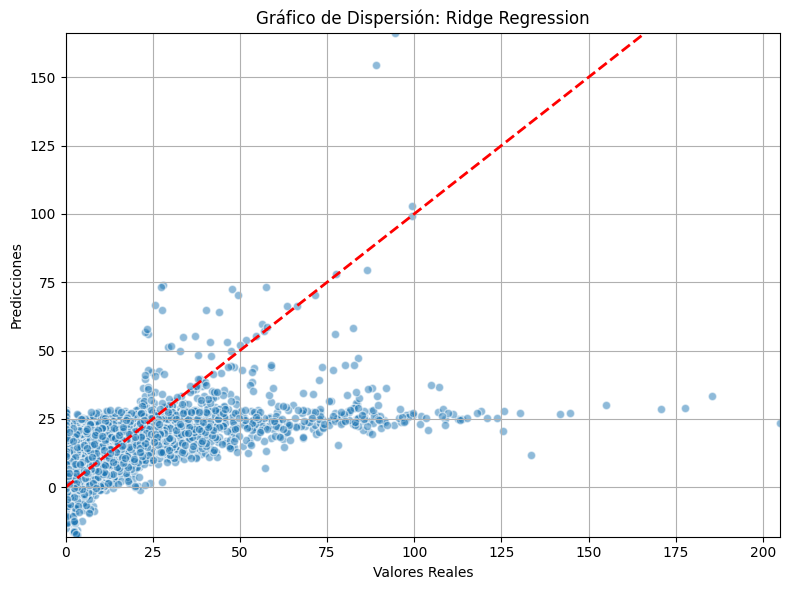

Performing grid search for Lasso Regression, 


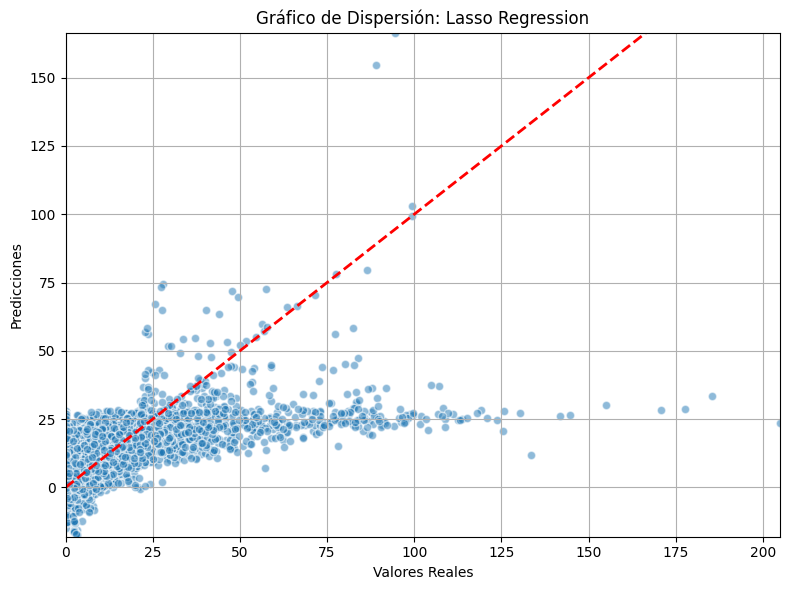

Performing grid search for Support Vector Regression, 


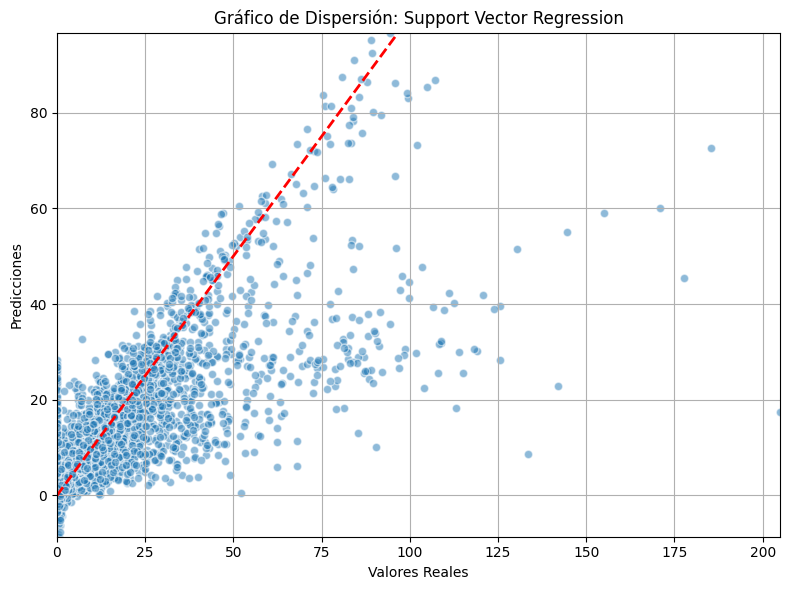

Performing grid search for Random Forest Regression, 


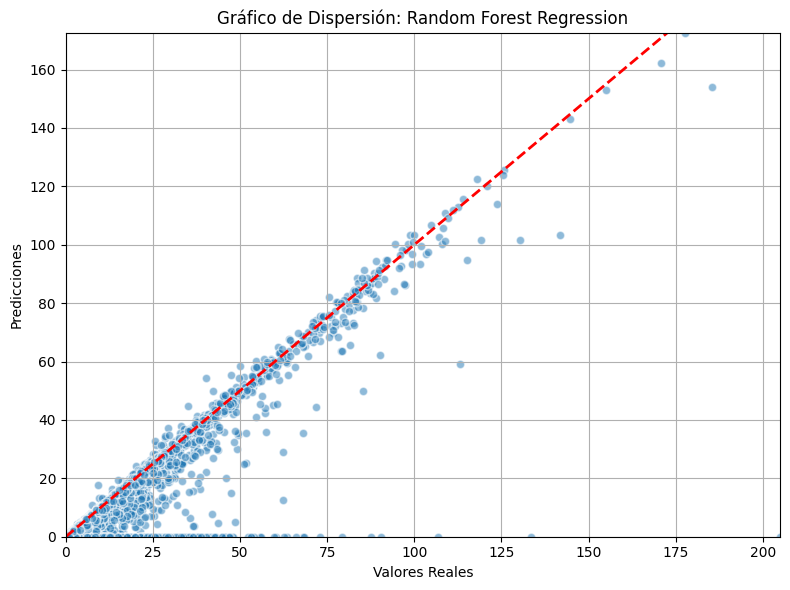

Performing grid search for Gradient Boosting Regression, 


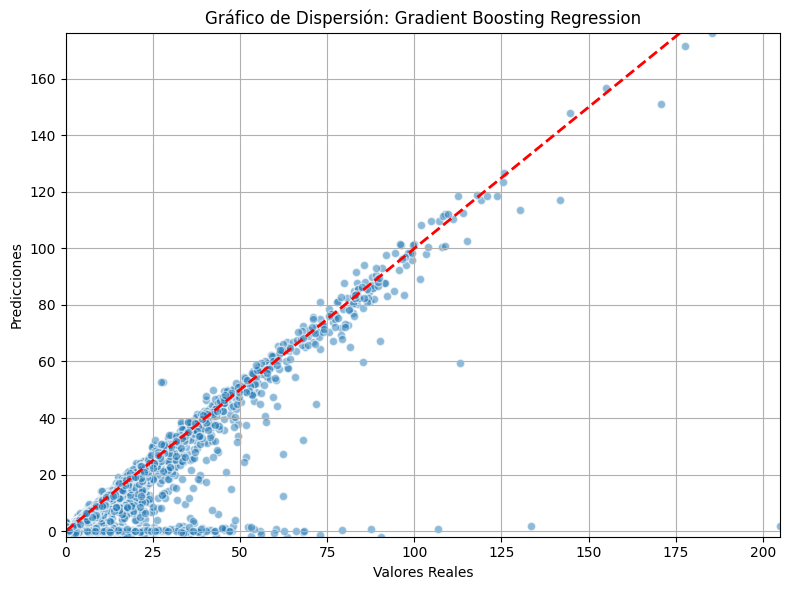

Performing grid search for Multi-layer Perceptron Regression, 


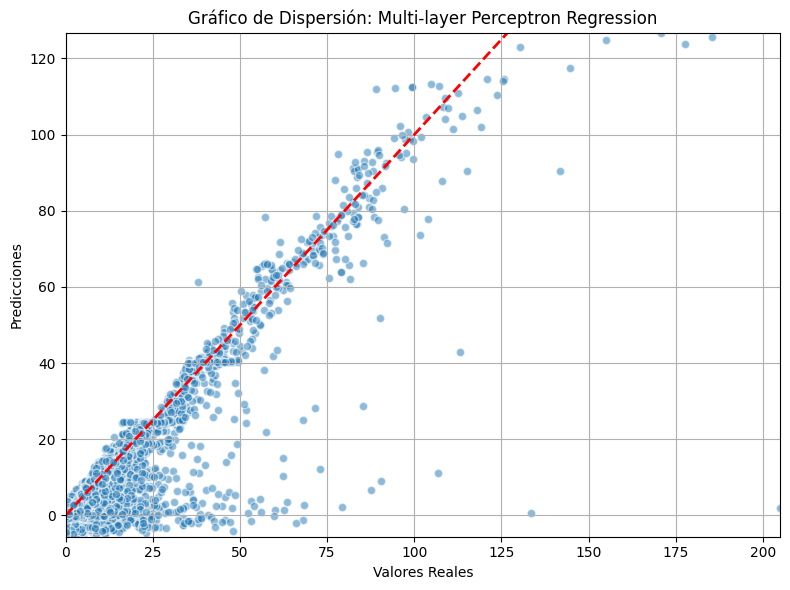

,Model,Best Parameters,Negative Mean Squared Error,Test MSE,R-squared (R2),Mean Absolute Error,Median Absolute Error
0,Linear Regression,{},256.895919,246.442097,0.294790,9.894332,6.466714
1,Ridge Regression,{'alpha': 0.1},256.895858,246.442892,0.294788,9.894223,6.466990
2,Lasso Regression,{'alpha': 0.001},256.961244,246.550151,0.294481,9.891601,6.440457
3,Support Vector Regression,"{'C': 10.0, 'epsilon': 1.0, 'kernel': 'rbf'}",155.364980,141.576673,0.594869,5.338989,1.935974
4,Random Forest Regression,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}",4.042838,60.801168,0.826014,2.883654,0.830900
5,Gradient Boosting Regression,"{'learning_rate': 0.2, 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200}",2.636981,60.269479,0.827535,2.993850,1.032120
6,Multi-layer Perceptron Regression,"{'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (15, 30), 'learning_rate_init': 0.001, 'solver': 'lbfgs'}",27.390228,72.144003,0.793555,4.071970,2.109109


In [1]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    make_scorer,
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    median_absolute_error,
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

warnings.filterwarnings("ignore")
pd.set_option("display.max_colwidth", None)

# Carga del dataset
data = pd.read_csv("./data/master_procesado.csv", sep=";", encoding="utf-8")

# Definición de las variables de regresión y objetivo
regression_features = [
    "country",
    "year",
    "sex",
    "age",
    "suicides_no",
    "population",
    "country-year",
    "HDI for year",
    "gdp_for_year ($)",
    "gdp_per_capita ($)",
    "generation",
]
regression_target = "suicides/100k pop"
data["suicides/100k pop"] = (
    data["suicides/100k pop"].str.replace(",", ".").astype(float)
)

# Cambiar todos los valores no categóricos como países a categóricos [0, 1, ...]
for feature in regression_features:
    if data[feature].dtype == "object":
        data[feature] = data[feature].astype("category").cat.codes

# Partición del dataset en train y test
X_reg = data[regression_features]
y_reg = data[regression_target]
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# Seleccionar los modelos de regresión a evaluar y sus hiperparámetros
regression_models = {
    "Linear Regression": (LinearRegression(), {}),
    "Ridge Regression": (Ridge(), {"alpha": [0.001, 0.01, 0.1, 1.0, 10.0]}),
    "Lasso Regression": (Lasso(), {"alpha": [0.001, 0.01, 0.1, 1.0, 10.0]}),
    "Support Vector Regression": (
        SVR(),
        {
            "C": [0.1, 1.0, 10.0],
            "epsilon": [0.01, 0.1, 1.0],
            "kernel": ["linear", "poly", "rbf"],
        },
    ),
    "Random Forest Regression": (
        RandomForestRegressor(),
        {
            "n_estimators": [50, 100, 200],
            "max_depth": [None, 10, 20, 30],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
        },
    ),
    "Gradient Boosting Regression": (
        GradientBoostingRegressor(),
        {
            "n_estimators": [50, 100, 200],
            "max_depth": [3, 4, 5],
            "learning_rate": [0.01, 0.1, 0.2],
            "min_samples_split": [2, 5, 10],
        },
    ),
    "Multi-layer Perceptron Regression": (
        MLPRegressor(),
        {
            "hidden_layer_sizes": [(5,), (15,), (30,), (5, 10), (15, 30), (5, 10, 15)],
            "activation": ["logistic", "tanh", "relu"],
            "alpha": [0.0001, 0.001, 0.01],
            "solver": ["adam", "lbfgs"],
            "learning_rate_init": [0.001, 0.01, 0.1],
        },
    ),
}


# Definición de las métricas de evaluación de los modelos
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)
mae_scorer = make_scorer(mean_absolute_error)
med_ae_scorer = make_scorer(median_absolute_error)

# Realizar la búsqueda de hiperparámetros para cada modelo de regresión con grid search y evaluarlo con las métricas definidas usando validación cruzada con 5 particiones
results = []

for model_name, (model, param_grid) in regression_models.items():
    print(f"Performing grid search for {model_name}, ")
    grid = GridSearchCV(model, param_grid, scoring=mse_scorer, cv=5, refit=True)
    grid.fit(StandardScaler().fit_transform(X_train_reg), y_train_reg)
    best_params = grid.best_params_
    neg_mean_squared_error = -grid.best_score_
    test_predictions = grid.predict(StandardScaler().fit_transform(X_test_reg))
    test_mse = mean_squared_error(y_test_reg, test_predictions)
    r2 = r2_score(y_test_reg, test_predictions)
    mae = mean_absolute_error(y_test_reg, test_predictions)
    med_ae = median_absolute_error(y_test_reg, test_predictions)

    results.append(
        {
            "Model": model_name,
            "Best Parameters": best_params,
            "Negative Mean Squared Error": neg_mean_squared_error,
            "Test MSE": test_mse,
            "R-squared (R2)": r2,
            "Mean Absolute Error": mae,
            "Median Absolute Error": med_ae,
        }
    )

    # Personalizar el gráfico de dispersión de los valores reales y las predicciones
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_reg, test_predictions, alpha=0.5, edgecolors="w")
    plt.xlabel("Valores Reales")
    plt.ylabel("Predicciones")
    plt.title(f"Gráfico de Dispersión: {model_name}")
    plt.grid(True)
    plt.xlim(min(y_test_reg), max(y_test_reg))
    plt.ylim(min(test_predictions), max(test_predictions))
    plt.plot(
        [min(y_test_reg), max(y_test_reg)],
        [min(y_test_reg), max(y_test_reg)],
        color="red",
        linestyle="--",
        lw=2,
    )
    plt.tight_layout()
    plt.show()

# Mostrar los resultados de la búsqueda de hiperparámetros y la evaluación de los modelos con las métricas definidas
results_df = pd.DataFrame(results)
display(results_df)

**Análisis de Resultados Actualizados**

1. **Modelos de Regresión Lineal, Ridge y Lasso**:
   - Regresión Lineal, Ridge y Lasso tienen errores cuadráticos medios (MSE) similares en el conjunto de entrenamiento, alrededor de 256.90, y en el conjunto de prueba, alrededor de 246.44. El coeficiente de determinación (R2) es aproximadamente 0.2947, lo que sugiere una capacidad limitada para explicar la variabilidad en los datos. El error absoluto mediano oscila alrededor de 6.46, indicando una discrepancia considerable entre las predicciones y los valores reales. En general, estos modelos no logran adaptarse adecuadamente a la complejidad de los datos, presentando un rendimiento insuficiente.

2. **Support Vector Regression (SVR)**:
   - SVR muestra un desempeño relativamente mejor en comparación con los modelos anteriores. Posee un MSE de alrededor de 155.36 en el conjunto de entrenamiento y 141.58 en el conjunto de prueba. El coeficiente de determinación (R2) es de aproximadamente 0.5949, indicando una capacidad moderada para explicar la variabilidad en los datos. El error absoluto mediano es aproximadamente 1.94, lo que sugiere que las predicciones tienden a desviarse menos de los valores reales en comparación con otros modelos.

3. **Random Forest Regression**:
   - El modelo de Regresión de Bosque Aleatorio muestra un rendimiento sólido con un MSE de aproximadamente 4.04 en el conjunto de entrenamiento y 60.80 en el conjunto de prueba. El coeficiente de determinación (R2) es de aproximadamente 0.8260, lo que indica una buena capacidad para explicar la variabilidad en los datos. El error absoluto mediano es aproximadamente 0.83, lo que sugiere que las predicciones tienden a estar muy cerca de los valores reales, destacando su buen rendimiento en comparación con otros modelos.

4. **Gradient Boosting Regression**:
   - El modelo de Regresión de Reforzamiento muestra un rendimiento similar al de Random Forest, con un MSE de aproximadamente 2.64 en el conjunto de entrenamiento y 60.27 en el conjunto de prueba. El coeficiente de determinación (R2) es de aproximadamente 0.8275, con un error absoluto mediano de alrededor de 1.03. Aunque tiene un buen rendimiento, el Random Forest parece superarlo ligeramente en este caso.

5. **Multi-layer Perceptron Regression (MLP)**:
   - El modelo de Regresión de Perceptrón Multicapa muestra un MSE de aproximadamente 27.39 en el conjunto de entrenamiento y 72.14 en el conjunto de prueba. El coeficiente de determinación (R2) es de aproximadamente 0.7936, con un error absoluto mediano de alrededor de 2.11. Aunque aceptable, no logra superar el rendimiento de los modelos basados en árboles (Random Forest y Gradient Boosting) en este contexto.

**Conclusión**:
   - Los modelos de Regresión Lineal, Ridge y Lasso siguen mostrando un rendimiento limitado, sin poder adaptarse adecuadamente a la complejidad de los datos. SVR mejora en rendimiento, pero Random Forest y Gradient Boosting son los más destacados, con Random Forest mostrando una mayor proximidad entre las predicciones y los valores reales. Aunque MLP es aceptable, no logra superar a los modelos basados en árboles en este contexto específico.